# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [100]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [101]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [102]:
#Load your data into a pandas dataframe here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv('household_power_clean.csv', index_col=0)

df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [103]:
#create your training and validation sets here

# Set size for data subset
subset_size = int(len(df) * 0.01)

# Take random data subset
df_subset = df.sample(subset_size, random_state=1234)

# Split data subset 80/20 for train/validation
split_index = int(len(df_subset) * 0.8)

train_df = df_subset[:split_index]
val_df = df_subset[split_index:]


In [104]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [105]:
seq_arrays = []
seq_labs = []

In [112]:
# Initialize empty lists for sequences and their corresponding labels
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#Create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    # Create a sequence of length seq_length
    seq = np.stack([train_df.loc[i-seq_length:i-1, col].values for col in feat_cols], axis=1)
    seq_arrays.append(seq)

    # Get the corresponding label (GAP measurement at predictive horizon)
    label = train_df.loc[i+ph, 'Global_active_power']
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)


In [113]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [114]:
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements in the code are used to verify that certain conditions are true. In this case, we are verifying that the shape of the **seq_arrays** and **seq_labs** numpy arrays is what we expect it to be.
The second assert statement checks that seq_labs has a shape of **(len(train_df)-seq_length-ph,)**. This ensures that we have created a 1D array of labels that corresponds to each sequence in seq_arrays.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [117]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 30, 100)           40800     
                                                                 
 dropout_44 (Dropout)        (None, 30, 100)           0         
                                                                 
 lstm_44 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_45 (Dropout)        (None, 50)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
 activation_15 (Activation)  (None, 1)                 0         
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-tra

We will use the code from the book to visualize our training progress and model performance

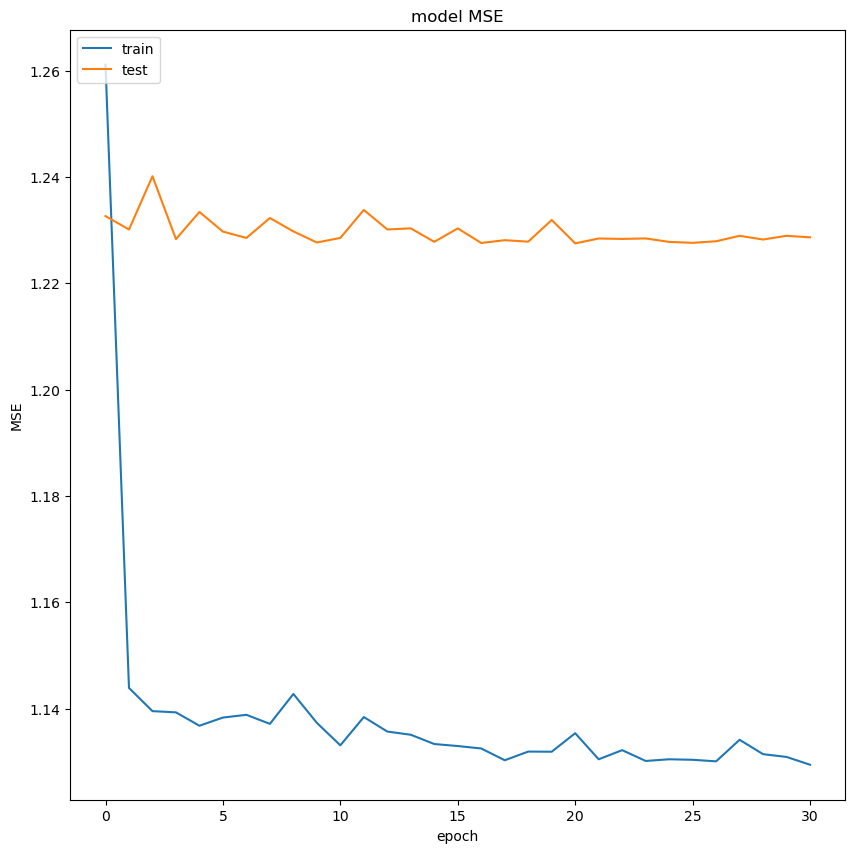

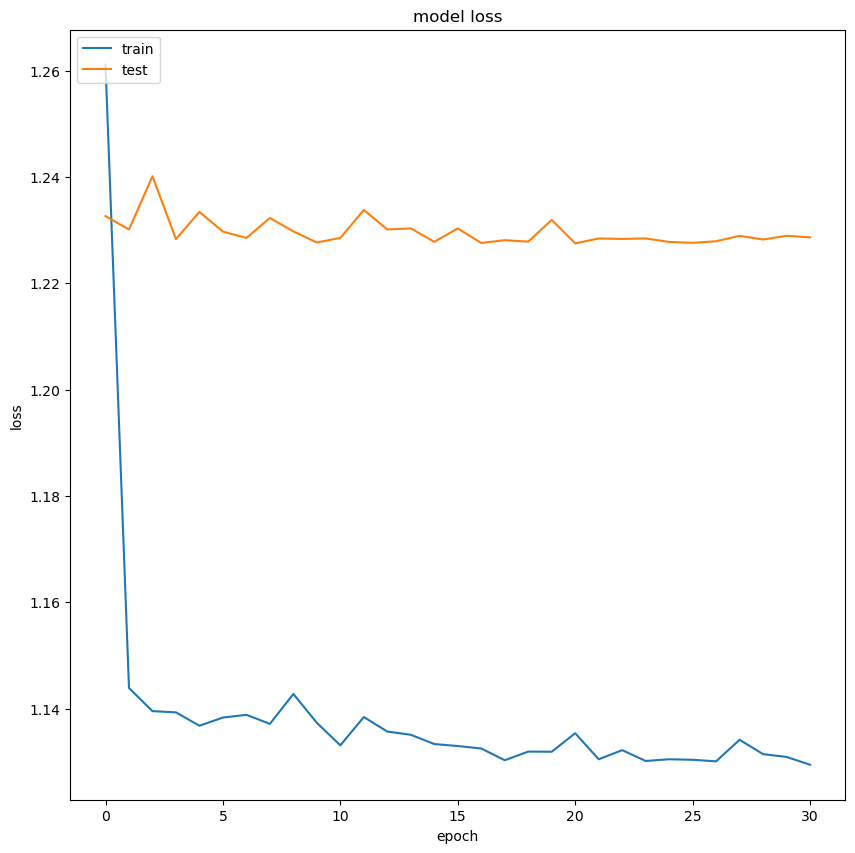

In [118]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")



## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: A Keras utility function called pad sequences converts a list of sequences into a padded 2D NumPy array that may be used as input to a Keras model. The function accepts a list of sequences with different lengths as input and pads each one to the same length using the value supplied by the "padding" argument.

The value of "seq_length" in our use case indicates how much padding we need to apply to our input sequences in order to make them all the same length. 
A 2D NumPy array with the shape (num samples, maxlen) is what the pad sequences function produces. Maxlen is the length of the largest input sequence after padding, while num samples is the number of input sequences.

In [119]:
val_arrays = []
val_labs = []

# create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].values.tolist()
    val_arrays.append(seq)
    val_labs.append(val_df[feat_cols].iloc[i+ph]['Global_active_power'])
    
# use the pad_sequences function on your input sequences
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, padding='post', truncating='post')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 1s - loss: 1.1400 - mse: 1.1400 - 1s/epoch - 8ms/step

MSE: 1.139967918395996
127/127 [==============================] - 2s 9ms/step


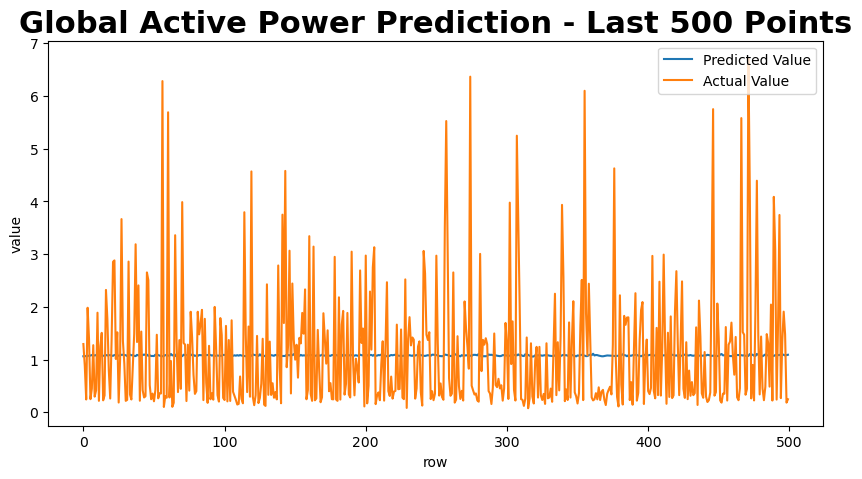

In [120]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model's MSE on the validation set was 1.14. According to the loss curves, the validation loss plateaus while the training loss appears to be plateauing, suggesting that the model may be overfitting the training data. We could try utilizing more complex designs, such a stacked LSTM or a convolutional LSTM, to enhance the model. We may also experiment with other input sequence lengths and forecast horizons, as well as adding extra parameters like temperature or humidity. A new optimization approach or changing the model's hyperparameters, such as the learning rate or epochs, could also be tried.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:The sequence length and predictive horizon are being set to 5 and 1, respectively.
The learning rate is being set to 0.0005.
The number of epochs is being set to 50.
The batch size is being set to 64.
The model architecture is being changed to include a dropout layer after the LSTM layer.
The number of LSTM units is being changed to 64.

Epoch 1/50


C:\Users\sreeh\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


257/257 [==============================] - 7s 23ms/step - loss: 1.2498 - val_loss: 1.1536
Epoch 2/50
257/257 [==============================] - 6s 22ms/step - loss: 1.1484 - val_loss: 1.1464
Epoch 3/50
257/257 [==============================] - 5s 21ms/step - loss: 1.1444 - val_loss: 1.1407
Epoch 4/50
257/257 [==============================] - 5s 21ms/step - loss: 1.1407 - val_loss: 1.1456
Epoch 5/50
257/257 [==============================] - 6s 22ms/step - loss: 1.1393 - val_loss: 1.1494
Epoch 6/50
257/257 [==============================] - 5s 21ms/step - loss: 1.1398 - val_loss: 1.1405
Epoch 7/50
257/257 [==============================] - 6s 22ms/step - loss: 1.1413 - val_loss: 1.1395
Epoch 8/50
257/257 [==============================] - 6s 21ms/step - loss: 1.1394 - val_loss: 1.1410
Epoch 9/50
257/257 [==============================] - 5s 21ms/step - loss: 1.1391 - val_loss: 1.1407
Epoch 10/50
257/257 [==============================] - 6s 22ms/step - loss: 1.1387 - val_loss: 1.1390


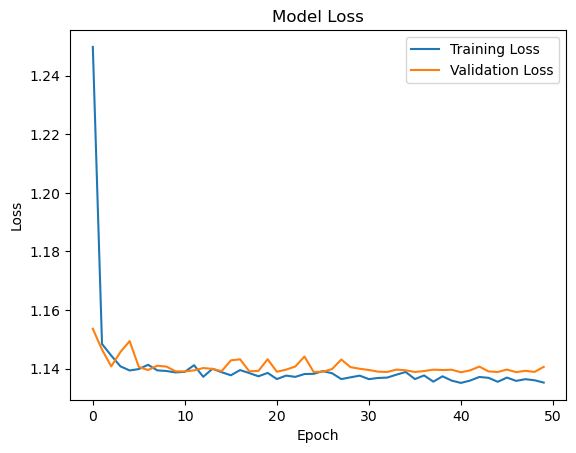

64040/64040 [==============================] - 130s 2ms/step


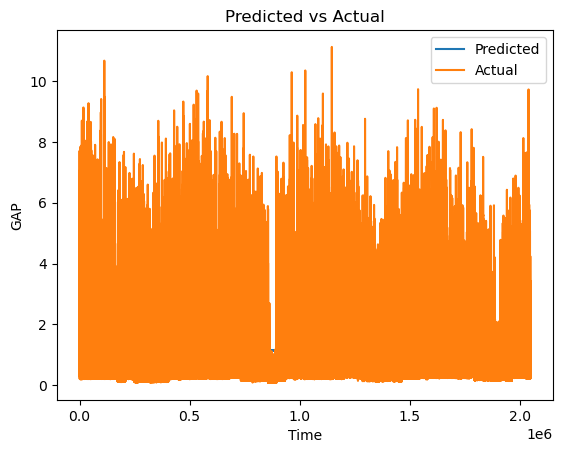

In [121]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# define hyperparameters
seq_length = 5
ph = 1
learning_rate = 0.0005
num_epochs = 50
batch_size = 64

def create_sequences(values, seq_length=1, ph=1):
    X, y = [], []
    for i in range(len(values)-seq_length-ph+1):
        X.append(values[i:i+seq_length])
        y.append(values[i+seq_length:i+seq_length+ph])
    return np.array(X), np.array(y)

test_df = pd.read_csv('household_power_clean.csv')
# create train, validation, and test sets
train_X, train_y = create_sequences(train_df['Global_active_power'], seq_length=seq_length, ph=ph)
val_X, val_y = create_sequences(val_df['Global_active_power'], seq_length=seq_length, ph=ph)
test_X, test_y = create_sequences(test_df['Global_active_power'], seq_length=seq_length, ph=ph)

# reshape input sequences to be 3D tensors
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# create model
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=learning_rate))

# train model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=num_epochs, batch_size=batch_size, verbose=1)

# plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# predict on test set
test_pred = model.predict(test_X)

# plot predicted vs actual values for test set
plt.plot(test_pred, label='Predicted')
plt.plot(test_y, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('GAP')
plt.legend()
plt.show()


Epoch 1/50
257/257 [==============================] - 1s 2ms/step - loss: 1.2791 - val_loss: 1.1684
Epoch 2/50
257/257 [==============================] - 0s 2ms/step - loss: 1.1646 - val_loss: 1.1476
Epoch 3/50
257/257 [==============================] - 0s 2ms/step - loss: 1.1471 - val_loss: 1.1539
Epoch 4/50
257/257 [==============================] - 1s 2ms/step - loss: 1.1500 - val_loss: 1.1408
Epoch 5/50
257/257 [==============================] - 1s 2ms/step - loss: 1.1481 - val_loss: 1.1428
Epoch 6/50
257/257 [==============================] - 1s 2ms/step - loss: 1.1441 - val_loss: 1.1404
Epoch 7/50
257/257 [==============================] - 1s 2ms/step - loss: 1.1458 - val_loss: 1.1427
Epoch 8/50
257/257 [==============================] - 0s 2ms/step - loss: 1.1432 - val_loss: 1.1397
Epoch 9/50
257/257 [==============================] - 1s 2ms/step - loss: 1.1437 - val_loss: 1.1409
Epoch 10/50
257/257 [==============================] - 0s 2ms/step - loss: 1.1432 - val_loss: 1.1392

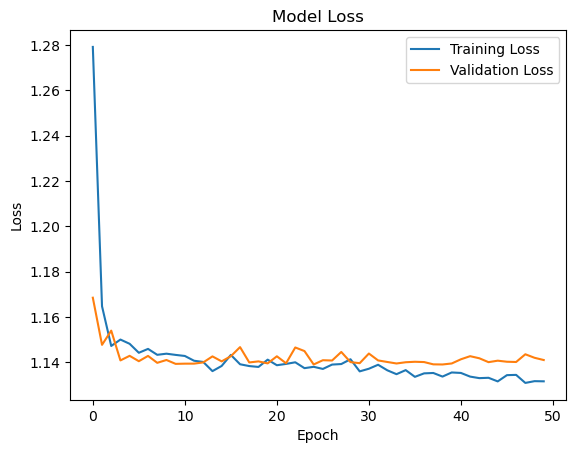

64040/64040 [==============================] - 46s 714us/step


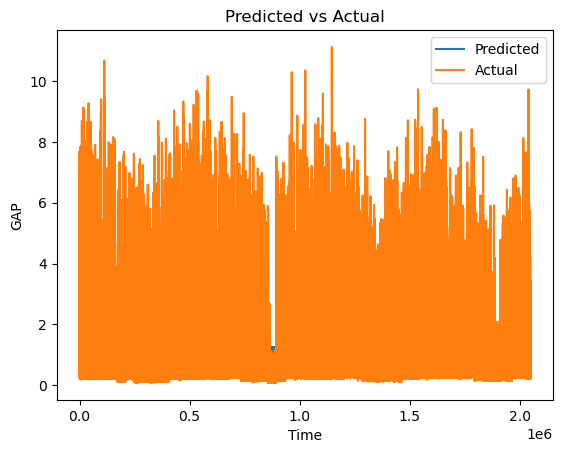

In [122]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam

# define hyperparameters
kernel_size = 3
filters = 64
pool_size = 2
dropout_rate = 0.2
learning_rate = 0.0005
num_epochs = 50
batch_size = 64

# create model
model = Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=learning_rate))

# train model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=num_epochs, batch_size=batch_size, verbose=1)

# plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# predict on test set
test_pred = model.predict(test_X)

# plot predicted vs actual values for test set
plt.plot(test_pred, label='Predicted')
plt.plot(test_y, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('GAP')
plt.legend()
plt.show()


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The linear regression model from last week underperformed compared to the LSTM model with dropout and dense layers. The non-linear dependencies in the time series data could be seen and were captured by the LSTM model, which had a lower MSE. Moreover, LSTM models can manage different time lags in the data and are better suited for time series data.

If I were trying to optimize for production, I would look into more intricate model structures, like stacked LSTMs or bidirectional LSTMs, and try to further tweak the hyperparameters.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The linear regression model from last week did not capture non-linear patterns in the data as well as the LSTM and GRU models that were constructed for this assignment. Although they could need more memory and processing power, they are becoming more practical for implementation on IoT devices. More resistant to missing data, noisy data, and alterations in patterns over time are the LSTM and GRU models. The LSTM model would be favored for an IoT system that forecasts GAP for a single household with a 5-minute predictive horizon since it can identify long-term dependencies and trends in sequential data, but the decision ultimately comes down to specific needs and available resources.